In [1]:

import os
import re
import json
from collections import Counter
from itertools import chain
from pathlib import Path
from typing import List, Dict, Union, Tuple, Any

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from PIL import Image
from sklearn.model_selection import StratifiedKFold
from torch.utils.data import DataLoader
from transformers import (
    DonutProcessor,
    VisionEncoderDecoderConfig,
    VisionEncoderDecoderModel,
    get_scheduler,
    Trainer,
    TrainingArguments
)
from datasets import load_dataset, Dataset, Image as ds_img
from polyleven import levenshtein  # a faster version of levenshtein

/home/amir/miniconda3/envs/doc-ai/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Load the SROIE-2019-V2 dataset
ds = load_dataset("rth/sroie-2019-v2")

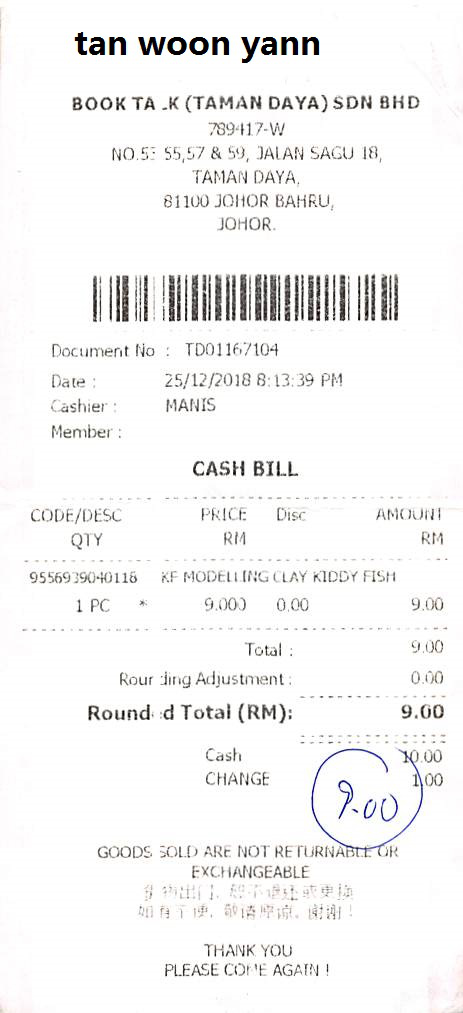

In [5]:
ds['train'][0]['image']

In [7]:
ds['train'][0]['objects']['entities']

{'company': 'BOOK TA .K (TAMAN DAYA) SDN BHD',
 'date': '25/12/2018',
 'address': 'NO.53 55,57 & 59, JALAN SAGU 18, TAMAN DAYA, 81100 JOHOR BAHRU, JOHOR.',
 'total': '9.00'}

In [8]:
import os
import json
from datasets import load_dataset

# Load the SROIE-2019-V2 dataset
ds = load_dataset("rth/sroie-2019-v2")

# Define the directory to save images
image_dir = "train/images"
os.makedirs(image_dir, exist_ok=True)

# List to store combined entities
combined_entities = []

# Iterate through the dataset
for idx, sample in enumerate(ds['train']):
    # Save the image
    image = sample['image']
    image_filename = f"image_{idx}.jpg"
    image_path = os.path.join(image_dir, image_filename)
    image.save(image_path)
    
    # Extract entities
    entities = sample['objects']['entities']
    
    # Append to the combined list
    combined_entities.append({
        'image': image_filename,
        'entities': entities
    })

# Save the combined entities to a JSON file
json_path = "train/entities.json"
with open(json_path, 'w') as json_file:
    json.dump(combined_entities, json_file, indent=4)

In [9]:
import os
import json
from datasets import load_dataset

# Load the SROIE-2019-V2 dataset
ds = load_dataset("rth/sroie-2019-v2")

# Define the directory to save images
image_dir = "test/images"
os.makedirs(image_dir, exist_ok=True)

# List to store combined entities
combined_entities = []

# Iterate through the dataset
for idx, sample in enumerate(ds['test']):
    # Save the image
    image = sample['image']
    image_filename = f"image_{idx}.jpg"
    image_path = os.path.join(image_dir, image_filename)
    image.save(image_path)
    
    # Extract entities
    entities = sample['objects']['entities']
    
    # Append to the combined list
    combined_entities.append({
        'image': image_filename,
        'entities': entities
    })

# Save the combined entities to a JSON file
json_path = "test/entities.json"
with open(json_path, 'w') as json_file:
    json.dump(combined_entities, json_file, indent=4)

In [10]:
import os
import json
from datasets import Dataset
from PIL import Image

def create_hf_dataset(images_dir: str, json_path: str) -> Dataset:
    """
    Creates a Hugging Face dataset from a directory of images and a JSON file containing entities.

    Args:
        images_dir (str): Path to the directory containing images.
        json_path (str): Path to the JSON file containing entities.

    Returns:
        Dataset: A Hugging Face Dataset with 'image' and 'entities' for each sample.
    """
    # Load entities from JSON file
    with open(json_path, 'r') as f:
        data = json.load(f)
    
    dataset_dict = {
        'image': [],
        'entities': []
    }
    
    for entry in data:
        image_filename = entry.get('image')
        entities = entry.get('entities', {})
        
        image_path = os.path.join(images_dir, image_filename)
        
        if not os.path.exists(image_path):
            print(f"Warning: Image {image_filename} not found in {images_dir}. Skipping.")
            continue
        
        try:
            # Load image
            with Image.open(image_path) as img:
                img = img.convert("RGB")
                dataset_dict['image'].append(img)
                dataset_dict['entities'].append(entities)
        except Exception as e:
            print(f"Error loading image {image_filename}: {e}")
    
    # Create Hugging Face Dataset
    hf_dataset = Dataset.from_dict(dataset_dict)
    
    return hf_dataset


# Create Hugging Face datasets for training and testing
train_images_dir = "train/images"
train_json_path = "train/entities.json"
train_dataset = create_hf_dataset(train_images_dir, train_json_path)

test_images_dir = "test/images"
test_json_path = "test/entities.json"
test_dataset = create_hf_dataset(test_images_dir, test_json_path)

In [11]:
train_dataset

Dataset({
    features: ['image', 'entities'],
    num_rows: 626
})

In [13]:
train_dataset

{'image': <PIL.PngImagePlugin.PngImageFile image mode=RGB size=463x1013>,
 'entities': {'address': 'NO.53 55,57 & 59, JALAN SAGU 18, TAMAN DAYA, 81100 JOHOR BAHRU, JOHOR.',
  'company': 'BOOK TA .K (TAMAN DAYA) SDN BHD',
  'date': '25/12/2018',
  'total': '9.00'}}

In [17]:
import os
import json
from datasets import Dataset, DatasetDict, Features, Value
from datasets import Image as HfImage
from typing import List, Dict, Any

def create_hf_dataset_dict(
    train_images_dir: str,
    train_json_path: str,
    test_images_dir: str,
    test_json_path: str
) -> DatasetDict:
    """
    Creates a Hugging Face DatasetDict with 'train' and 'test' splits from separate image directories and JSON files.

    Args:
        train_images_dir (str): Path to the directory containing training images.
        train_json_path (str): Path to the JSON file containing training entities.
        test_images_dir (str): Path to the directory containing testing images.
        test_json_path (str): Path to the JSON file containing testing entities.

    Returns:
        DatasetDict: A DatasetDict containing 'train' and 'test' splits.
    """
    
    def load_dataset_from_dir(images_dir: str, json_path: str) -> Dataset:
        """
        Loads a dataset from an images directory and a corresponding JSON file.

        Args:
            images_dir (str): Path to the directory containing images.
            json_path (str): Path to the JSON file containing entities.

        Returns:
            Dataset: A Hugging Face Dataset with 'image' and 'entities' for each sample.
        """
        # Load entities from JSON file
        with open(json_path, 'r') as f:
            data = json.load(f)
        
        dataset_dict = {
            'image': [],
            'entities': []
        }
        
        for entry in data:
            image_filename = entry.get('image')
            entities = entry.get('entities', {})
            
            image_path = os.path.join(images_dir, image_filename)
            
            if not os.path.exists(image_path):
                print(f"Warning: Image {image_filename} not found in {images_dir}. Skipping.")
                continue
            
            # Store the image path instead of the PIL Image object
            dataset_dict['image'].append(image_path)
            dataset_dict['entities'].append(entities)
        
        # Define the dataset features
        features = Features({
            'image': HfImage(),
            'entities': Value('string')  # Adjust the type based on your 'entities' structure
        })
        
        # Convert entities dict to JSON strings for serialization
        # This is necessary because 'entities' are dictionaries
        for i in range(len(dataset_dict['entities'])):
            dataset_dict['entities'][i] = json.dumps(dataset_dict['entities'][i])
        
        # Create Hugging Face Dataset with defined features
        hf_dataset = Dataset.from_dict(dataset_dict, features=features)
        return hf_dataset

    # Load training dataset
    print("Loading training dataset...")
    train_dataset = load_dataset_from_dir(train_images_dir, train_json_path)
    print(f"Training dataset loaded with {len(train_dataset)} samples.")

    # Load testing dataset
    print("Loading testing dataset...")
    test_dataset = load_dataset_from_dir(test_images_dir, test_json_path)
    print(f"Testing dataset loaded with {len(test_dataset)} samples.")

    # Create DatasetDict
    dataset_dict = DatasetDict({
        "train": train_dataset,
        "test": test_dataset
    })

    print("DatasetDict created with 'train' and 'test' splits.")
    return dataset_dict

# Example Usage:

# Define paths
train_images_directory = "train/images"
train_entities_json = "train/entities.json"
test_images_directory = "test/images"
test_entities_json = "test/entities.json"

# Create the DatasetDict
dataset_dict = create_hf_dataset_dict(
    train_images_dir=train_images_directory,
    train_json_path=train_entities_json,
    test_images_dir=test_images_directory,
    test_json_path=test_entities_json
)

# Display the DatasetDict
print(dataset_dict)

Loading training dataset...
Training dataset loaded with 626 samples.
Loading testing dataset...
Testing dataset loaded with 347 samples.
DatasetDict created with 'train' and 'test' splits.
DatasetDict({
    train: Dataset({
        features: ['image', 'entities'],
        num_rows: 626
    })
    test: Dataset({
        features: ['image', 'entities'],
        num_rows: 347
    })
})


In [21]:
ds_new = dataset_dict

In [25]:
ds_new['train'][0]

{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=463x1013>,
 'entities': '{"company": "BOOK TA .K (TAMAN DAYA) SDN BHD", "date": "25/12/2018", "address": "NO.53 55,57 & 59, JALAN SAGU 18, TAMAN DAYA, 81100 JOHOR BAHRU, JOHOR.", "total": "9.00"}'}

In [26]:
ds_new.save_to_disk("sroie_2019_v2")

Saving the dataset (1/1 shards): 100%|██████████| 347/347 [00:00<00:00, 3224.63 examples/s]
